In [1]:
import numpy as np
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert

In [2]:
data = ert.load("010.dat")
print(data)

Data: Sensors: 392 data: 2849, nonzero entries: ['a', 'b', 'm', 'n', 'r', 'valid']


In [3]:
data["k"] = ert.geometricFactors(data)
data["rhoa"] = data["r"] * data["k"]
data.estimateError(relativeError=0.02, absoluteError=0.07)

In [4]:
x0 = data.subset(x=0)
x0.setSensors(np.column_stack([pg.y(x0), pg.x(x0)])) # auto for x/y
# x0.show()
print(x0)

Data: Sensors: 14 data: 71, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'r', 'rhoa', 'valid']


In [5]:
y1 = data.subset(y=0.6)
y1.setSensors(y1.sensors() * np.array([1, 0, 0]))  # auto
# y1.show()
print(y1)

Data: Sensors: 14 data: 139, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'r', 'rhoa', 'valid', 'ya', 'yb', 'ym', 'yn']


In [8]:
mesh = mt.createParaMesh(y1, paraDepth=1.2, paraDX=0.3, quality=34.4, smooth=True)

In [9]:
mgr = ert.Manager(y1)
mgr.setMesh(mesh)
mgr.invert(zWeight=0.3, verbose=True)

18/03/24 - 11:34:04 - pyGIMLi - INFO - Found 2 regions.
18/03/24 - 11:34:04 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
18/03/24 - 11:34:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
18/03/24 - 11:34:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
18/03/24 - 11:34:04 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 1791 Cells: 3408 Boundaries: 2642
18/03/24 - 11:34:04 - pyGIMLi - INFO - Use median(data values)=1195.6100000000017
18/03/24 - 11:34:04 - pyGIMLi - INFO - Created startmodel from forward operator: 391, min/max=1195.610000/1195.610000
18/03/24 - 11:34:04 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000002D8A9CC98B0>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000002D8A80AB540>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000002D8A889BB80>
min/max (data): 524/2199
min/max (error): 2%/2.01%
min/max (start model): 1196/1196
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  228.65
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   16.51 (dPhi = 92.64%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    0.84 (dPhi = 92.69%) lam: 20.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.84)                   #
################################################################################


391 [1415.5192099378614,...,1327.741058326155]

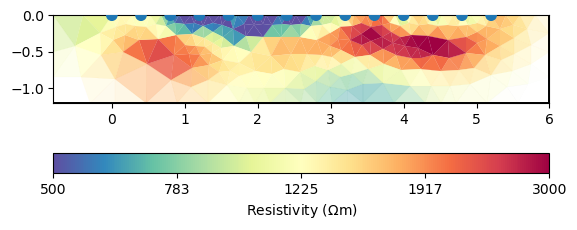

In [10]:
kw = dict(cMin=500, cMax=3000, cMap="Spectral_r", logScale=True)#,
mgr.showResult(**kw);

In [11]:
from pygimli.physics.petro import transFwdArchieS # , transInvArchieS

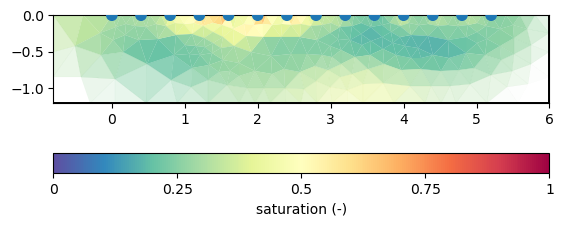

In [13]:
tS = transFwdArchieS(rFluid=66*(1-0.02*20), phi=0.4, m=1.3, n=1.83)
sat = tS.inv(mgr.model)
mgr.showResult(sat, cMin=0, cMax=1, logScale=0, label="saturation (-)");

Detecting small distances, using mm accuracy


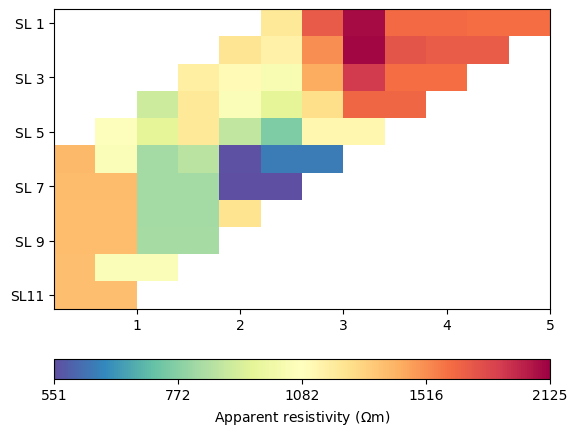

In [14]:
# tS = transFwdArchieS(66*(1-0.02*20), phi=0.4, m=1.3, n=1.83)
fop = pg.frameworks.PetroModelling(mgr.fop, tS)
response = fop.response(sat)
y1.show(response);

18/03/24 - 11:39:03 - pyGIMLi - INFO - Found 2 regions.
18/03/24 - 11:39:03 - pyGIMLi - INFO - Region with smallest marker set to background (marker=1)


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x2d8b179c2e0>)

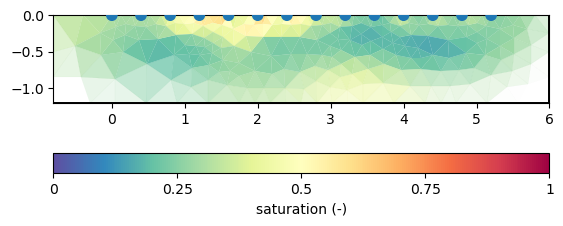

In [17]:
fop.setMesh(mesh)
inv = pg.Inversion(fop=fop)
inv.setRegularization(1, background=True)
inv.setRegularization(2, limits=[0, 1], zWeight=0.3)
# startModel = pg.Vector(len(sat), 0.2)
model = inv.run(y1["rhoa"], relativeError=y1["err"], startModel=0.2)  # startModel)
mgr.showModel(model, cMin=0, cMax=1, logScale=0, label="saturation (-)")

In [50]:
xpos = [1, 1.5, 2, 2.5]
pos = np.array([[x, -0.1] for x in xpos] + [[x, -0.5] for x in xpos])
pointSat = pg.cat(np.ones_like(xpos) * 0.5, np.ones_like(xpos) * 0.2)

In [23]:
invmesh = mgr.paraDomain
invmesh["marker"] = 0
pointFop = pg.frameworks.PriorModelling(invmesh, pos)

18/03/24 - 11:50:42 - pyGIMLi - INFO - Found 1 regions.


18/03/24 - 11:52:32 - pyGIMLi - INFO - Use median(data values)=0.35
18/03/24 - 11:52:32 - pyGIMLi - INFO - Created startmodel from forward operator: 391, min/max=0.350000/0.350000
18/03/24 - 11:52:32 - pyGIMLi - INFO - Creating GeostatisticConstraintsMatrix for region 0 with: I=[3, 0.5], dip=0, strike=0
18/03/24 - 11:52:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
18/03/24 - 11:52:32 - pyGIMLi - INFO - (C) Time for eigenvalue decomposition 0.1s
18/03/24 - 11:52:32 - pyGIMLi - INFO - Cache stored: C:\Guenther.T\Anwendungsdaten\pygimli\Cache\5909074572380075405


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x2d8b1916490>)

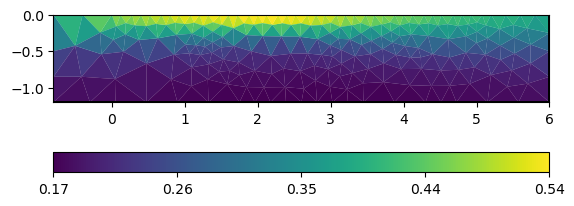

In [25]:
invP = pg.Inversion(fop=pointFop)
invP.setRegularization(correlationLengths=[3, 0.5])
modelP = invP.run(pointSat, absoluteError=0.03)
pg.show(invmesh, modelP)

In [59]:
fopJoint = pg.frameworks.JointModelling([fop, pointFop])
fopJoint.setData([y1, pointSat])
invJoint = pg.Inversion(fopJoint)
dataVec = pg.cat(y1["rhoa"], pointSat)
errorVec = pg.cat(y1["err"], 0.03/pointSat)
invJoint.setRegularization(cType=2) # correlationLengths=[1, 0.2])
modelJoint = invJoint.run(dataVec, relatativeError=errorVec, lam=300, startModel=0.2, verbose=True)

18/03/24 - 12:08:11 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.frameworks.modelling.JointModelling object at 0x000002D8BD950F90>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000002D8BD7AA6A0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000002D8BB252B20>
min/max (data): 0.2/2199
min/max (error): 1%/1%
min/max (start model): 0.2/0.2
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 15759.18
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =  453.48 (dPhi = 97.06%) lam: 300.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   54.67 (dPhi = 87.80%) lam: 300.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    9.47 (dPhi = 78.68%) lam: 300.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    2.65 (dPhi = 54.24%) lam: 300.0
--

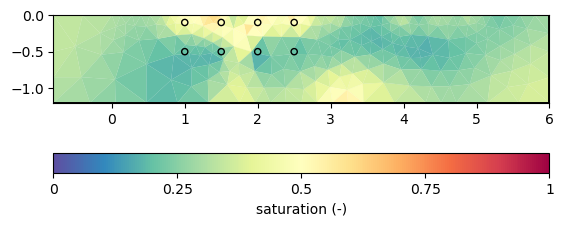

In [60]:
ax, cb = pg.show(invmesh, modelJoint, cMin=0, cMax=1, logScale=0, label="saturation (-)", cMap="Spectral_r")
ax.scatter(pos[:, 0], pos[:, 1], c=pointSat, s=20, vmin=0, vmax=1, cmap="Spectral_r", ec="black")

In [52]:
pos

array([[ 1. , -0.1],
       [ 1.5, -0.1],
       [ 2. , -0.1],
       [ 2.5, -0.1],
       [ 1. , -0.5],
       [ 1.5, -0.5],
       [ 2. , -0.5],
       [ 2.5, -0.5]])